# Probability of default: credit scoring model

This model uses a Kaggle dataset containing data about credit repayment difficulty rates among customers and will be used to predict which individuals are most likely to default on their loans, based on their historical loan repayment behavior and transactional activities.

**Solution description:**

Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years. 

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The objective of this challenge is to create a robust machine-learning model to predict which individuals are most likely to default on their loans, based on their historical loan repayment behavior and transactional activities.


---

The variables are the following:

**SeriousDlqin2yrs** Person experienced 90 days past due delinquency or worse (Target variable / label)

**RevolvingUtilizationOfUnsecuredLines**: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

**age** Age of borrower in years

**NumberOfTime30-59DaysPastDueNotWorse**: Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

**DebtRatio**: Monthly debt payments, alimony,living costs divided by monthy gross income

**MonthlyIncome**: Monthly income

**NumberOfOpenCreditLinesAndLoans**: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

**NumberOfTimes90DaysLate**: Number of times borrower has been 90 days or more past due.

**NumberRealEstateLoansOrLines**: Number of mortgage and real estate loans including home equity lines of credit

**NumberOfTime60-89DaysPastDueNotWorse**: Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

**NumberOfDependents**: Number of dependents in family excluding themselves (spouse, children etc.)

---

We will be using a random forest classifier for two reasons: firstly, because it would allow us to quickly and easily change the output to a simple binary classification problem. Secondly, because the predict_proba functionality allows us to output a probability score (probability of 1), this score is what we will use for predicting the probability of 90 days past due delinquency or worse in 2 years time.

---

Furthermore, we will predominantly be adopting a quantiles based approach in order to streamline the process as much as possible so that hypothetical credit checks can be returned as easily and as quickly as possible.


In [99]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

ModuleNotFoundError: No module named 'sklearn.ensemble.gradient_boosting'

# Exploratory Data Analysis

In [100]:
train = pd.read_csv("cs-training.csv")
kaggle_test = pd.read_csv("cs-test.csv")

In [20]:
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [21]:
train.shape

(150000, 12)

In [22]:
train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [24]:
train.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

SeriousDlqin2yrs is the target variable (label), it is binary.

The training set contains 150,000 observations of 11 features and 1 label.

All of our features are numerical in nature.

NumberOfDependents and MonthlyIncome contain NaN values, we also suspect that other variables contains errors (Age).

In [97]:
kaggle_test.isnull().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

The test data also contains several NaN values

## Target distribution

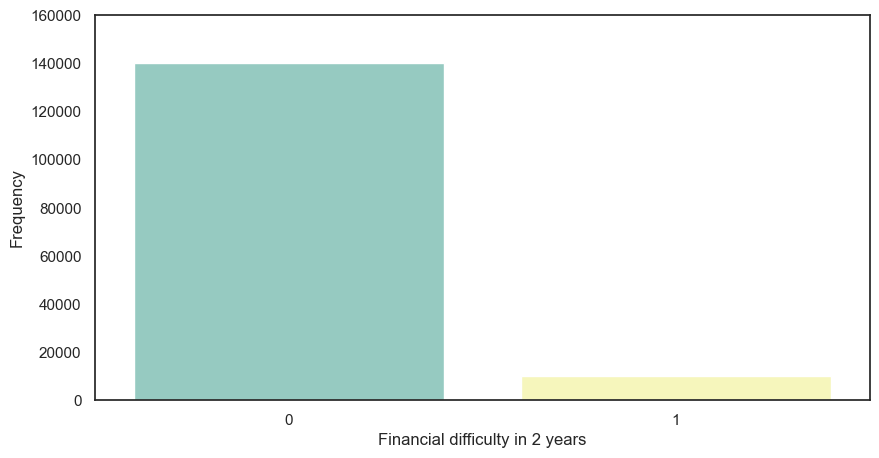

In [25]:
ax = sns.countplot(x = train.SeriousDlqin2yrs ,palette="Set3")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel('Financial difficulty in 2 years')
ax.set_ylabel('Frequency')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

plt.show()

We can see that the distribution of our target variable is very skewed.

## Detecting outliers

In [26]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

# detect outliers from Age, SibSp , Parch and Fare
# These are the numerical features present in the dataset
Outliers_to_drop = detect_outliers(train,2,["RevolvingUtilizationOfUnsecuredLines",
                                            "age",
                                            "NumberOfTime30-59DaysPastDueNotWorse",
                                            "DebtRatio",
                                            "MonthlyIncome",
                                            "NumberOfOpenCreditLinesAndLoans",
                                            "NumberOfTimes90DaysLate",
                                            "NumberRealEstateLoansOrLines",
                                            "NumberOfTime60-89DaysPastDueNotWorse",
                                            "Unnamed: 0",
                                            "NumberOfDependents"])

In [27]:
train.loc[Outliers_to_drop]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
900,901,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
919,920,1,1.362142,73,1,274.000000,NaN,2,3,0,1,NaN
1958,1959,0,1.634551,28,0,151.000000,NaN,1,3,0,2,0.0
4852,4853,0,1.566866,46,2,0.104983,6000.0,3,2,0,0,0.0
5956,5957,0,2.237856,60,6,2597.000000,1.0,16,1,2,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
117338,117339,1,0.960692,42,0,1.241580,3770.0,29,1,2,1,3.0
126682,126683,1,0.344297,38,0,1.789158,4500.0,23,14,11,1,0.0
129570,129571,0,0.075067,58,0,0.298925,17388.0,24,0,6,1,0.0
5833,5834,1,0.917527,44,0,1.852144,3800.0,13,1,7,1,1.0


We detected 3527 outliers in the training set, which represents 2.53% of our training data. We will drop these outliers.

In [28]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## Merging datasets

In [29]:
train_len = len(train)
dataset =  pd.concat(objs=[train, kaggle_test], axis=0).reset_index(drop=True)

In [30]:
dataset.shape

(247976, 12)

In [31]:
dataset = dataset.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

train = train.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

kaggle_test = kaggle_test.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

## Exploring variables

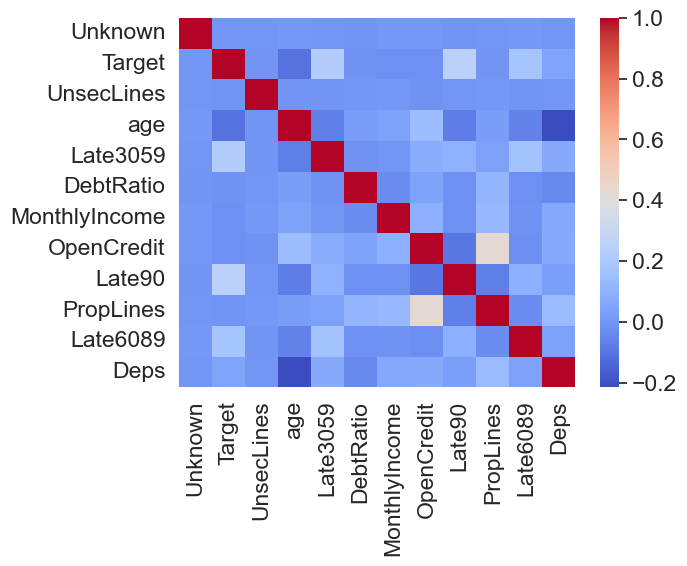

In [32]:
# Correlation matrix
g = sns.heatmap(train.corr(),annot=False, fmt = ".2f", cmap = "coolwarm")

We can see that the Target has the highest correlation with age, previous late payments, and the number of dependants.

## Exploring UnsecLines

In [33]:
dataset.UnsecLines.describe()

count    247976.000000
mean          5.678007
std         229.111400
min           0.000000
25%           0.029372
50%           0.148802
75%           0.544452
max       50708.000000
Name: UnsecLines, dtype: float64

In [34]:
dataset.UnsecLines = pd.qcut(dataset.UnsecLines.values, 5).codes

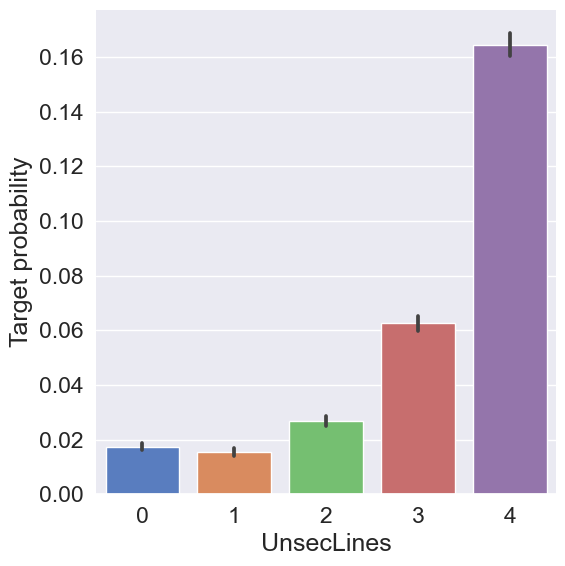

In [35]:
# Explore UnsecLines feature vs Target
g  = sns.factorplot(x="UnsecLines",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

We can that there is an almost exponential relationship between this variable and our target.

## Exploring Age

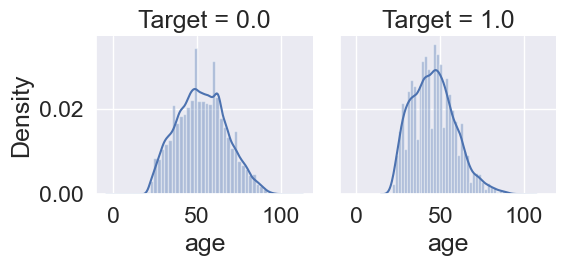

In [36]:
# Explore Age vs Survived
g = sns.FacetGrid(dataset, col='Target')
g = g.map(sns.distplot, "age")

In [37]:
dataset.age = pd.qcut(dataset.age.values, 5).codes

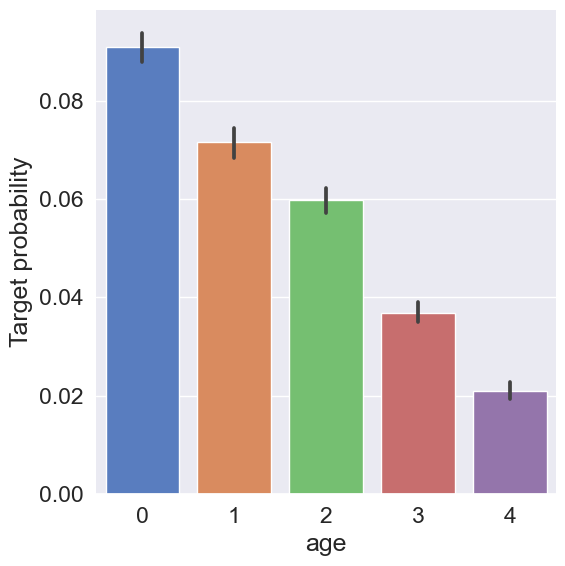

In [38]:
# Explore age feature vs Target
g  = sns.factorplot(x="age",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

We can see that age has an inverse relationship to default risk

## Exploring Late3059

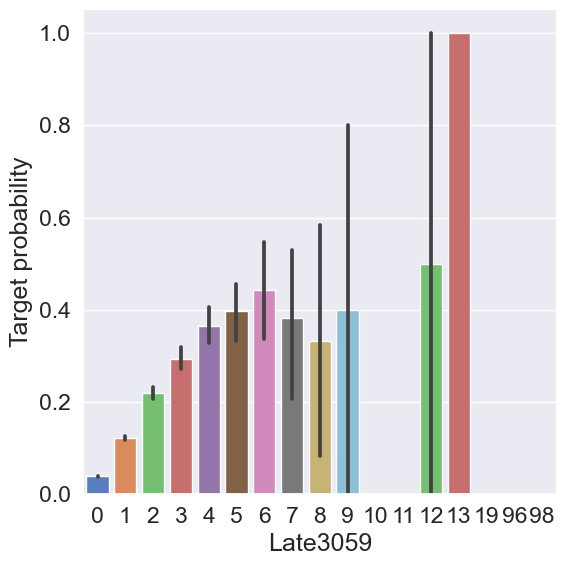

In [39]:
# Explore UnsecLines feature vs Target
g  = sns.factorplot(x="Late3059",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [40]:
for i in range(len(dataset)):
    if dataset.Late3059[i] >= 6:
        dataset.Late3059[i] = 6

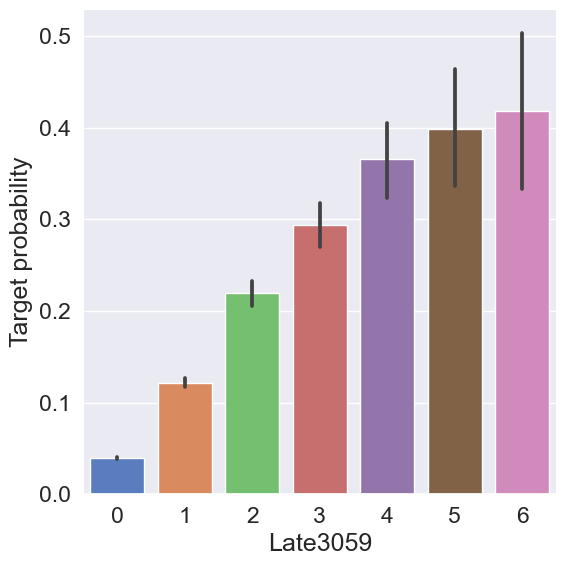

In [41]:
# Explore UnsecLines feature vs Target
g  = sns.factorplot(x="Late3059",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

Due to very high standard deviations we decided to group customers who have 6 or more late payments together. We can see that this has boosted the predictive capacity and reduced the variance of Late3059

## Exploring DebtRatio

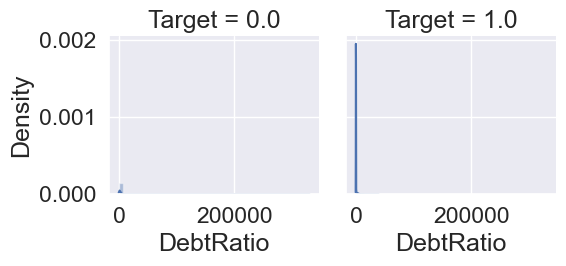

In [42]:
# Explore Age vs Survived
g = sns.FacetGrid(dataset, col='Target')
g = g.map(sns.distplot, "DebtRatio")

In [43]:
dataset.DebtRatio = pd.qcut(dataset.DebtRatio.values, 5).codes

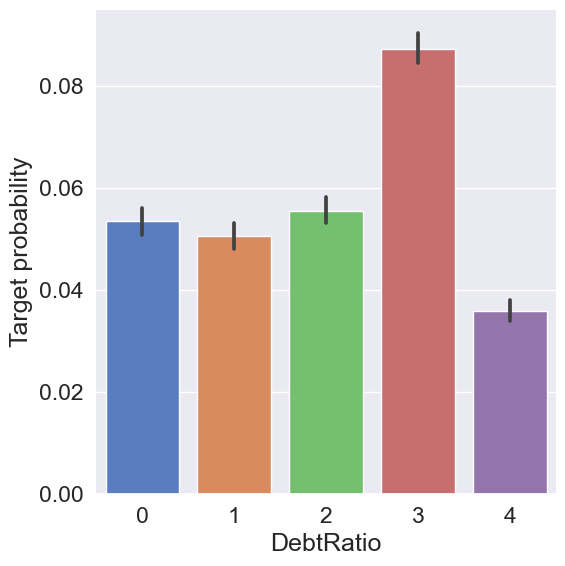

In [44]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="DebtRatio",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

## Exploring MonthlyIncome

In [45]:
dataset.MonthlyIncome.isnull().sum()

48352

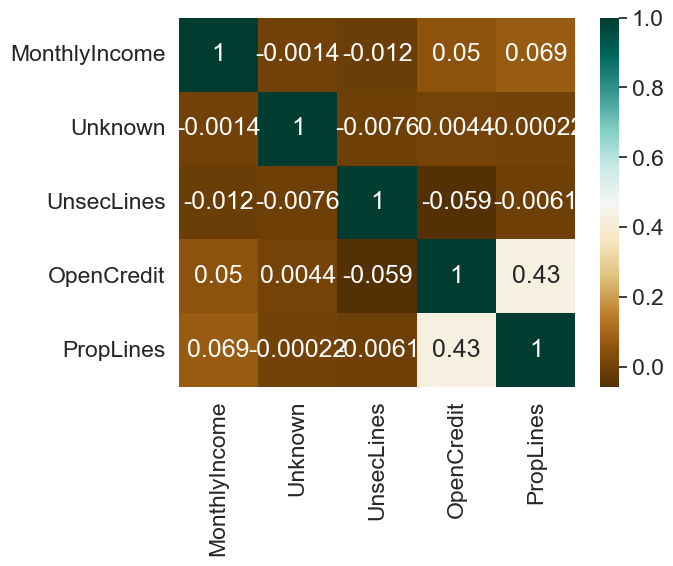

In [46]:
g = sns.heatmap(dataset[["MonthlyIncome","Unknown","UnsecLines","OpenCredit","PropLines"]].corr(),cmap="BrBG",annot=True)

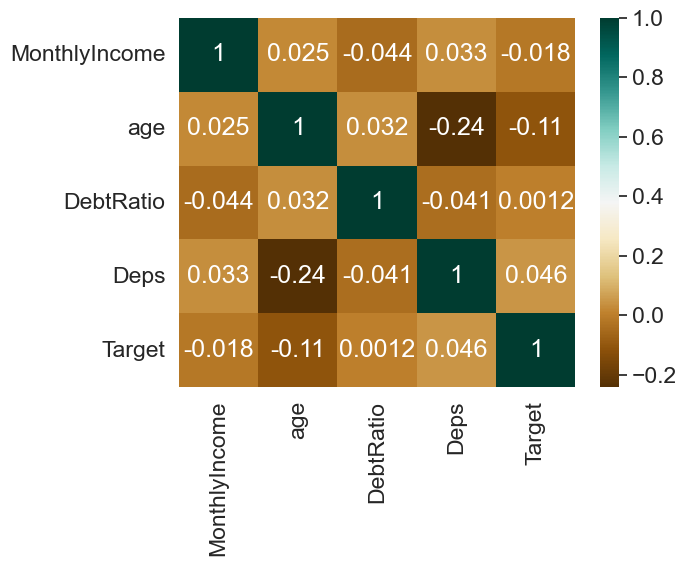

In [47]:
g = sns.heatmap(dataset[["MonthlyIncome","age","DebtRatio","Deps","Target"]].corr(),cmap="BrBG",annot=True)

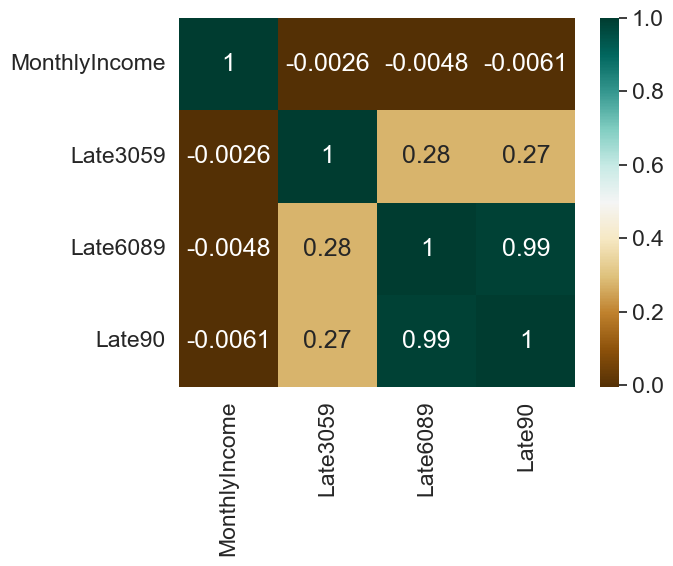

In [48]:
g = sns.heatmap(dataset[["MonthlyIncome","Late3059","Late6089","Late90"]].corr(),cmap="BrBG",annot=True)

We can see that MonthlyIncome has no strong correlation with any other variable so we cannot accurately estimate the NaN values. Thus, we will fill the NaN with the median value

In [49]:
dataset.MonthlyIncome.median()

5414.0

In [50]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset.MonthlyIncome = dataset.MonthlyIncome.fillna(dataset.MonthlyIncome.median())

In [51]:
dataset.MonthlyIncome = pd.qcut(dataset.MonthlyIncome.values, 5).codes

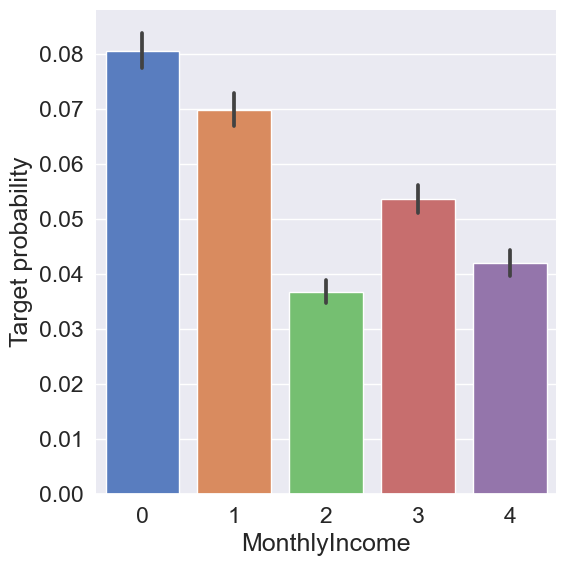

In [52]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="MonthlyIncome",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

## Exploring OpenCredit

In [53]:
dataset.OpenCredit.describe()

count    247976.000000
mean          8.457516
std           5.109915
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          85.000000
Name: OpenCredit, dtype: float64

In [54]:
dataset.OpenCredit = pd.qcut(dataset.OpenCredit.values, 5).codes

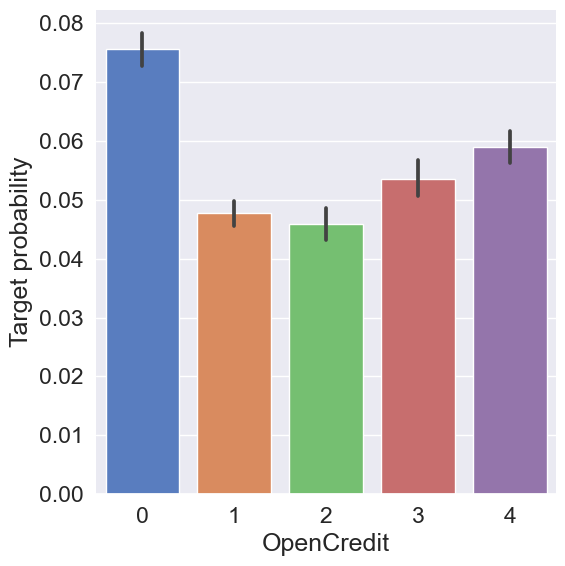

In [55]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="OpenCredit",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

## Exploring Late90

In [56]:
dataset.Late90.describe()

count    247976.000000
mean          0.156894
std           2.906148
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: Late90, dtype: float64

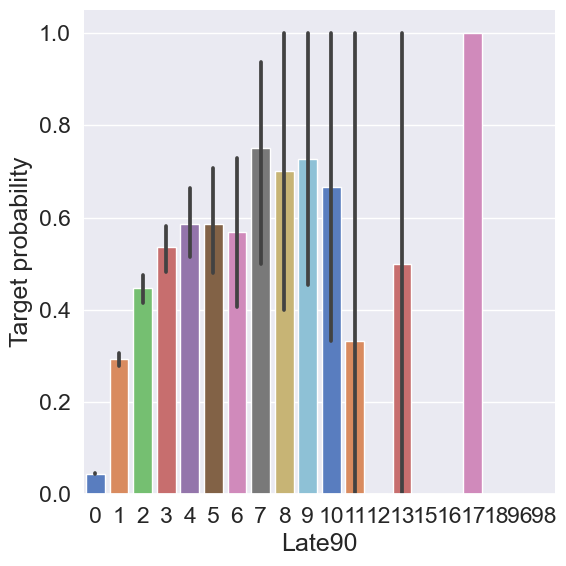

In [57]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="Late90",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [58]:
for i in range(len(dataset)):
    if dataset.Late90[i] >= 5:
        dataset.Late90[i] = 5

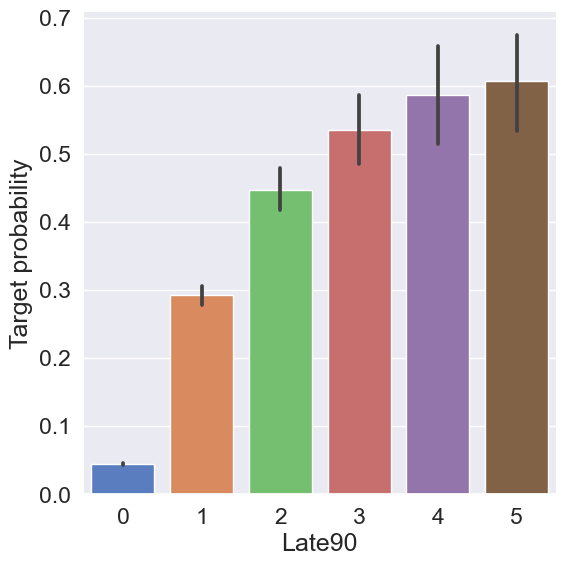

In [59]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="Late90",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

## Exploring PropLines

In [60]:
dataset.PropLines.describe()

count    247976.000000
mean          1.013703
std           1.092993
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          37.000000
Name: PropLines, dtype: float64

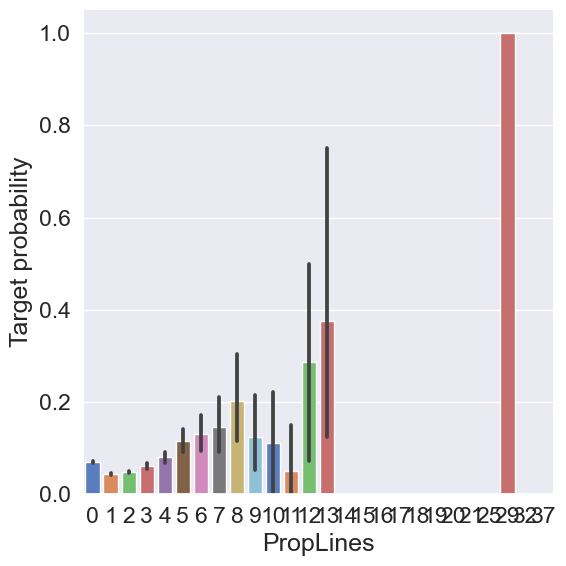

In [61]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="PropLines",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [62]:
for i in range(len(dataset)):
    if dataset.PropLines[i] >= 6:
        dataset.PropLines[i] = 6

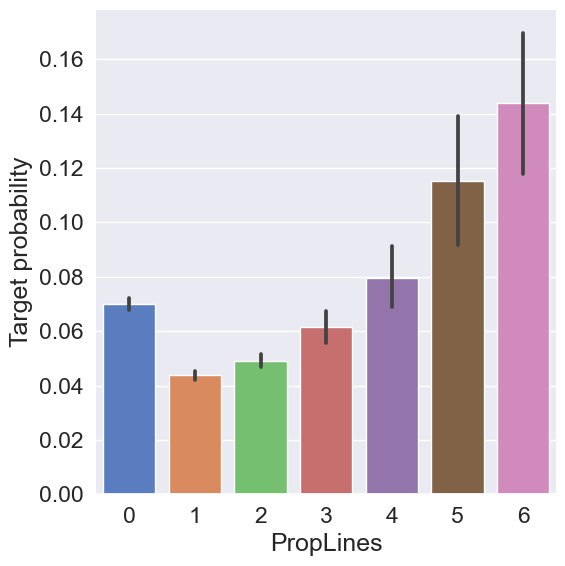

In [63]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="PropLines",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

## Exploring Late6089

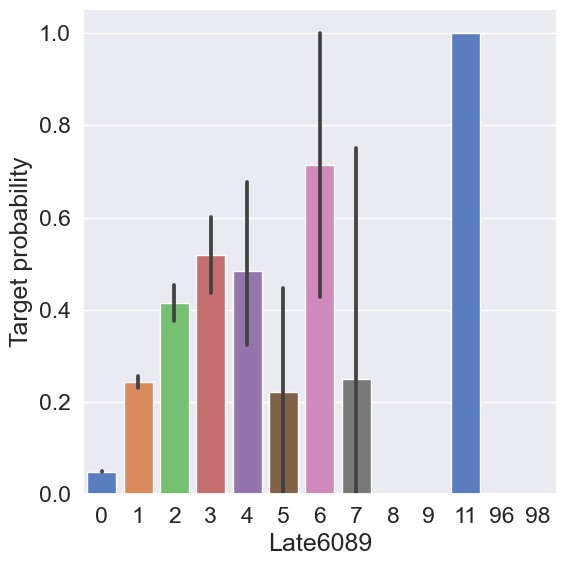

In [64]:
# Explore Late6089 feature quantiles vs Target
g  = sns.factorplot(x="Late6089",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [65]:
for i in range(len(dataset)):
    if dataset.Late6089[i] >= 3:
        dataset.Late6089[i] = 3

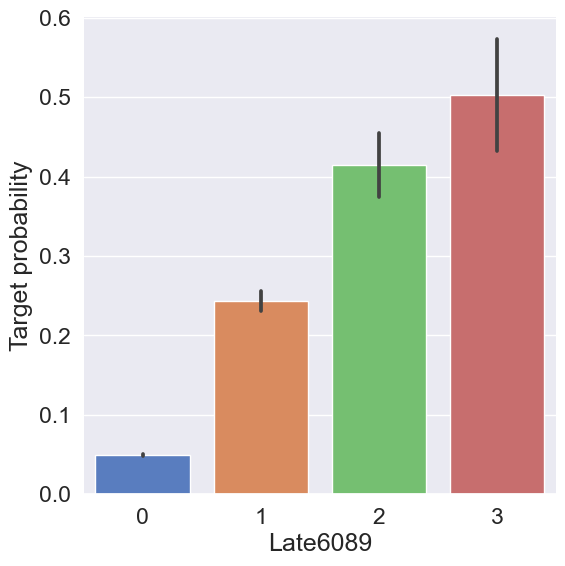

In [66]:
# Explore Late6089 feature quantiles vs Target
g  = sns.factorplot(x="Late6089",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

## Exploring Deps

In [67]:
dataset.Deps.describe()

count    241584.000000
mean          0.761561
std           1.123201
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          43.000000
Name: Deps, dtype: float64

In [68]:
dataset.Deps = dataset.Deps.fillna(dataset.Deps.median())

In [69]:
dataset.Deps.isnull().sum()

0

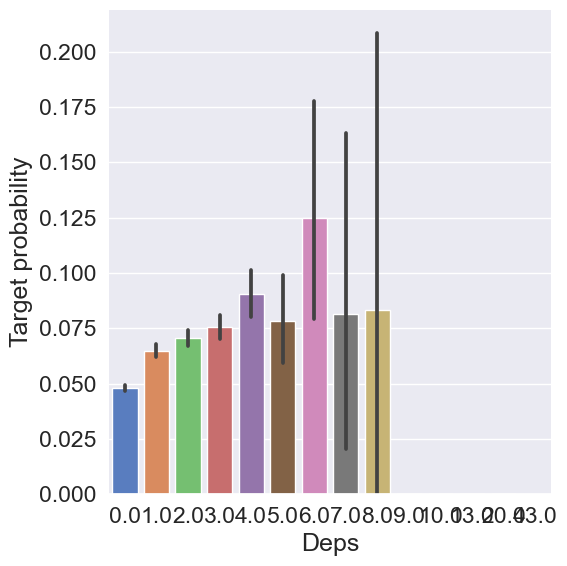

In [70]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="Deps",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

In [71]:
for i in range(len(dataset)):
    if dataset.Deps[i] >= 4:
        dataset.Deps[i] = 4

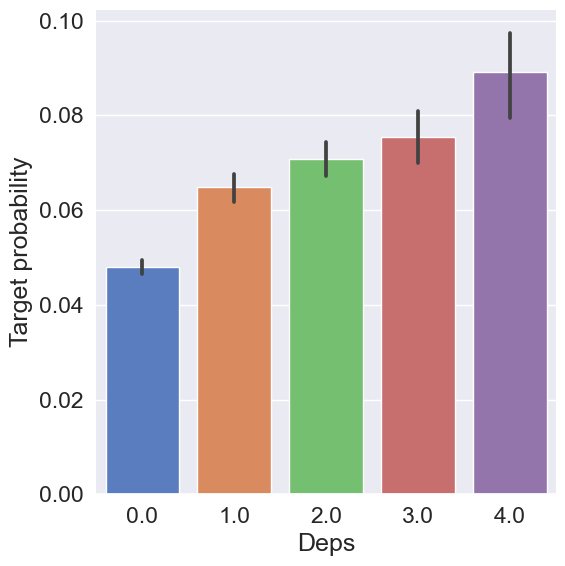

In [72]:
# Explore DebtRatio feature quantiles vs Target
g  = sns.factorplot(x="Deps",y="Target",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Target probability")

## Final NaN check

In [73]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247976 entries, 0 to 247975
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unknown        247976 non-null  int64  
 1   Target         146473 non-null  float64
 2   UnsecLines     247976 non-null  int8   
 3   age            247976 non-null  int8   
 4   Late3059       247976 non-null  int64  
 5   DebtRatio      247976 non-null  int8   
 6   MonthlyIncome  247976 non-null  int8   
 7   OpenCredit     247976 non-null  int8   
 8   Late90         247976 non-null  int64  
 9   PropLines      247976 non-null  int64  
 10  Late6089       247976 non-null  int64  
 11  Deps           247976 non-null  float64
dtypes: float64(2), int64(5), int8(5)
memory usage: 14.4 MB


In [74]:
dataset.head()

,Unknown,Target,UnsecLines,age,Late3059,DebtRatio,MonthlyIncome,OpenCredit,Late90,PropLines,Late6089,Deps
0,1,1.0,4,1,2,3,4,4,0,6,0,2.0
1,2,0.0,4,1,0,0,0,0,0,0,0,1.0
2,3,0.0,3,0,1,0,0,0,1,0,0,0.0
3,4,0.0,2,0,0,0,0,1,0,0,0,0.0
4,5,0.0,4,2,1,0,4,1,0,1,0,0.0


Building binary/dummy variables

In [75]:
dataset = pd.get_dummies(dataset, columns = ["UnsecLines"], prefix="UnsecLines")
dataset = pd.get_dummies(dataset, columns = ["age"], prefix="age")
dataset = pd.get_dummies(dataset, columns = ["Late3059"], prefix="Late3059")
dataset = pd.get_dummies(dataset, columns = ["DebtRatio"], prefix="DebtRatio")
dataset = pd.get_dummies(dataset, columns = ["MonthlyIncome"], prefix="MonthlyIncome")
dataset = pd.get_dummies(dataset, columns = ["OpenCredit"], prefix="OpenCredit")
dataset = pd.get_dummies(dataset, columns = ["Late90"], prefix="Late90")
dataset = pd.get_dummies(dataset, columns = ["PropLines"], prefix="PropLines")
dataset = pd.get_dummies(dataset, columns = ["Late6089"], prefix="Late6089")
dataset = pd.get_dummies(dataset, columns = ["Deps"], prefix="Deps")

In [76]:
dataset.head()

,Unknown,Target,UnsecLines_0,UnsecLines_1,UnsecLines_2,UnsecLines_3,UnsecLines_4,age_0,age_1,age_2,age_3,age_4,Late3059_0,Late3059_1,Late3059_2,Late3059_3,Late3059_4,Late3059_5,Late3059_6,DebtRatio_0,DebtRatio_1,DebtRatio_2,DebtRatio_3,DebtRatio_4,MonthlyIncome_0,MonthlyIncome_1,MonthlyIncome_2,MonthlyIncome_3,MonthlyIncome_4,OpenCredit_0,OpenCredit_1,OpenCredit_2,OpenCredit_3,OpenCredit_4,Late90_0,Late90_1,Late90_2,Late90_3,Late90_4,Late90_5,PropLines_0,PropLines_1,PropLines_2,PropLines_3,PropLines_4,PropLines_5,PropLines_6,Late6089_0,Late6089_1,Late6089_2,Late6089_3,Deps_0.0,Deps_1.0,Deps_2.0,Deps_3.0,Deps_4.0
0,1,1.0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
1,2,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,3,0.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,4,0.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,5,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [77]:
dataset.shape

(247976, 56)

## Building our credit scoring model

In [78]:
train = dataset[:train_len]
Kaggle_test = dataset[train_len:]
Kaggle_test.drop(labels=["Target"],axis = 1,inplace=True)

In [79]:
Kaggle_test.shape

(101503, 55)

In [80]:
## Separate train features and label 

train["Target"] = train["Target"].astype(int)

Y_train = train["Target"]

X_train = train.drop(labels = ["Target", "Unknown"],axis = 1)

In [81]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, Y_train)

In [82]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

<AxesSubplot:ylabel='feature'>

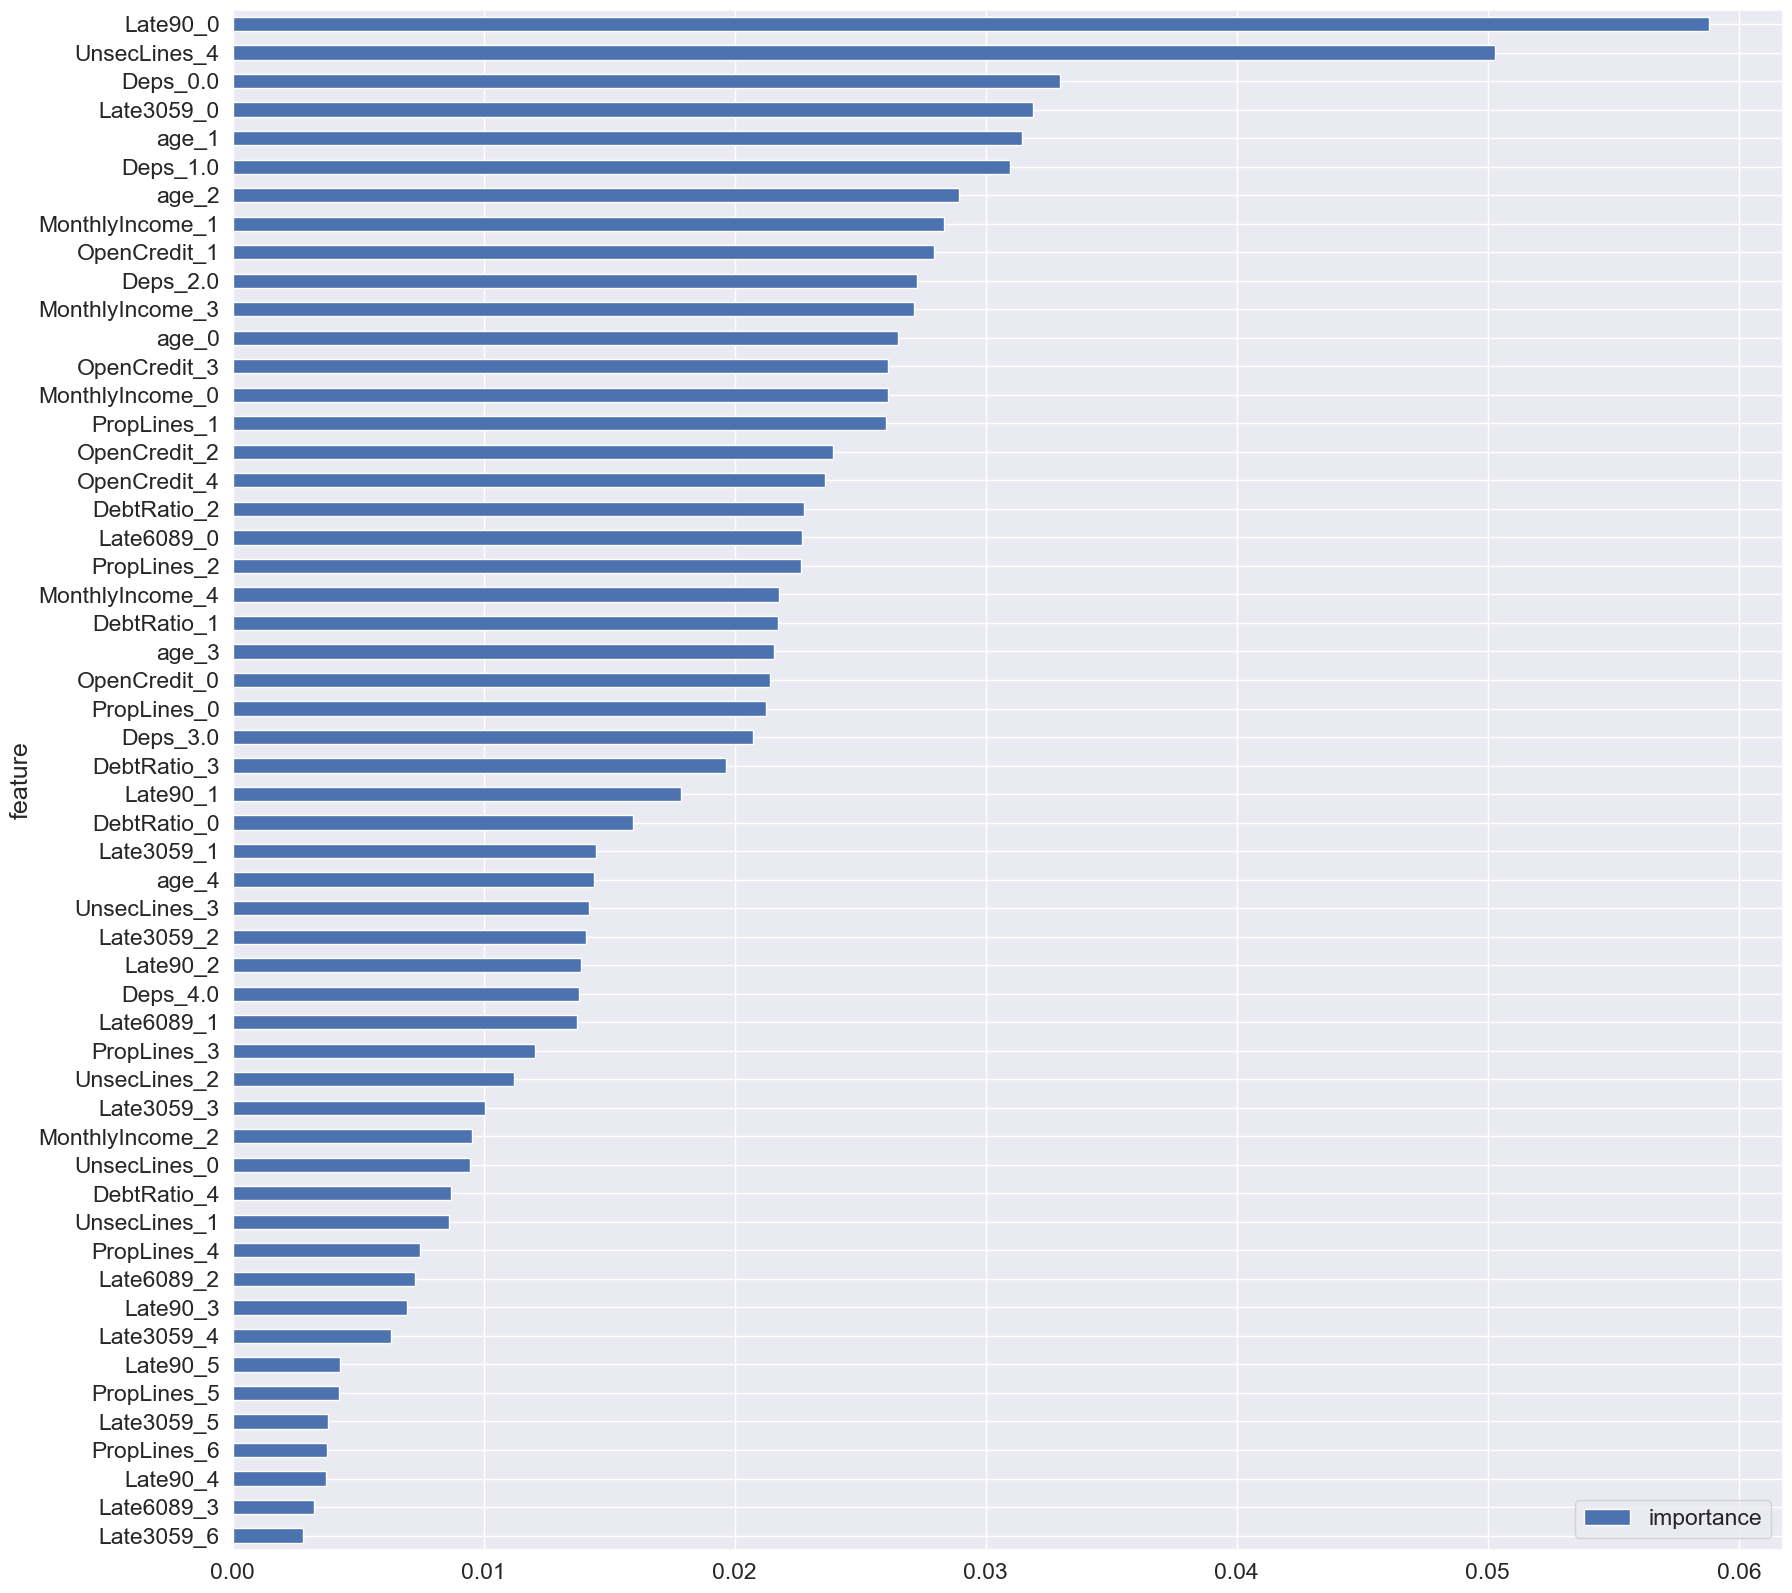

In [83]:
features.plot(kind='barh', figsize=(20, 20))

In [91]:
parameters = {'n_estimators': 1000, 'random_state' : 20}
    
model = RandomForestClassifier(**parameters)
model.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=1000, random_state=20)

In [92]:
Kaggle_test.head()

,Unknown,UnsecLines_0,UnsecLines_1,UnsecLines_2,UnsecLines_3,UnsecLines_4,age_0,age_1,age_2,age_3,age_4,Late3059_0,Late3059_1,Late3059_2,Late3059_3,Late3059_4,Late3059_5,Late3059_6,DebtRatio_0,DebtRatio_1,DebtRatio_2,DebtRatio_3,DebtRatio_4,MonthlyIncome_0,MonthlyIncome_1,MonthlyIncome_2,MonthlyIncome_3,MonthlyIncome_4,OpenCredit_0,OpenCredit_1,OpenCredit_2,OpenCredit_3,OpenCredit_4,Late90_0,Late90_1,Late90_2,Late90_3,Late90_4,Late90_5,PropLines_0,PropLines_1,PropLines_2,PropLines_3,PropLines_4,PropLines_5,PropLines_6,Late6089_0,Late6089_1,Late6089_2,Late6089_3,Deps_0.0,Deps_1.0,Deps_2.0,Deps_3.0,Deps_4.0
146473,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
146474,2,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
146475,3,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
146476,4,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
146477,5,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [101]:
results_df = pd.read_csv("cs-test.csv")

In [102]:
results_df = results_df.drop(["RevolvingUtilizationOfUnsecuredLines",
                             "age",
                             "NumberOfTime30-59DaysPastDueNotWorse",
                             "DebtRatio",
                             "MonthlyIncome",
                             "NumberOfOpenCreditLinesAndLoans",
                             "NumberOfTimes90DaysLate",
                             "NumberRealEstateLoansOrLines",
                             "NumberOfTime60-89DaysPastDueNotWorse",
                             "NumberOfDependents"], axis=1)

In [103]:
DefaultProba = model.predict_proba(Kaggle_test.drop(["Unknown"], axis=1))
DefaultProba = DefaultProba[:,1]
results_df.SeriousDlqin2yrs = DefaultProba

results_df = results_df.rename(columns={'Unnamed: 0': 'Id',
                                        'SeriousDlqin2yrs': 'Probability'})

In [104]:
results_df.head()

,Id,Probability
0,1,0.000000
1,2,0.033382
2,3,0.000000
3,4,0.139584
4,5,0.120869


In [105]:
results_df.to_csv("KAGGLE_CREDIT_SCORE.csv", index=False)

This model lead to an accuracy rate of 0.800498 on Kaggle's unseen test data.

I deem this accuracy rate to be acceptable given that we used a relatively simple quantile based approach and in light of the fact that no parameter optimization was undertaken. 